In [1]:
import os
import cv2
import datetime
import json
import torch
import copy
import shutil
import ultralytics
from glob import glob
import re
import hashlib
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from ultralytics import YOLO

base_path = '/home/dl.net/evezzali/datasets/Datasets - Organized/'

In [2]:
train_val_test_split = [0.6, 0.1, 0.3]

train_val_test_split = np.array(train_val_test_split)/np.sum(train_val_test_split)
th1 = train_val_test_split[0]
th2 = th1+train_val_test_split[1]

train_files = []
val_files = []
test_files = []
img_paths = glob(f'{base_path}yolo_dataset/images/*.jpg')
img_paths.extend(glob(f'{base_path}yolo_dataset/images/*.JPG'))
img_paths = list(set(img_paths))

for img_path in img_paths:
    file_name = os.path.basename(img_path)
    hash_code = int(hashlib.sha256(file_name.encode('utf-8')).hexdigest(), 16) % 10 ** 4
    if hash_code < th1 * (10 ** 4):
        train_files.append(img_path)
    elif hash_code < th2 * (10 ** 4):
        val_files.append(img_path) 
    else:
        test_files.append(img_path)
print(len(train_files), len(val_files), len(test_files))

5100 877 2616


In [3]:
glob(f'{base_path}yolo_dataset/*.txt')

['/home/dl.net/evezzali/datasets/Datasets - Organized/yolo_dataset/train.txt',
 '/home/dl.net/evezzali/datasets/Datasets - Organized/yolo_dataset/val.txt',
 '/home/dl.net/evezzali/datasets/Datasets - Organized/yolo_dataset/test.txt']

In [4]:
#Generate txt files
string = ""

for img_path in train_files:
    file_name = os.path.basename(img_path)
    string = f'{string}{base_path}yolo_dataset/images/{file_name}' + '\n'

with open(f'{base_path}yolo_dataset/train.txt', 'w') as f:
    f.write(string)

string = ""

for img_path in test_files:
    file_name = os.path.basename(img_path)
    string = f'{string}{base_path}yolo_dataset/images/{file_name}' + '\n'

with open(f'{base_path}yolo_dataset/test.txt', 'w') as f:
    f.write(string)

string = ""

for img_path in val_files:
    file_name = os.path.basename(img_path)
    string = f'{string}{base_path}yolo_dataset/images/{file_name}' + '\n'

with open(f'{base_path}yolo_dataset/val.txt', 'w') as f:
    f.write(string)



In [7]:
torch.cuda.is_available()

False

In [3]:
device = torch.device('cuda:1')

In [4]:
model = YOLO("yolov8m.pt")  # load a pretrained model (recommended for training)
model.to(device);

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [5]:
model.train(data=f'{base_path}yolo_dataset/data.yaml', epochs=200, imgsz=640, patience=10)

New https://pypi.org/project/ultralytics/8.0.205 available 😃 Update with 'pip install -U ultralytics'
/home/dl.net/evezzali/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD Ryzen Threadripper PRO 5965WX 24-Cores)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/home/dl.net/evezzali/datasets/Datasets - Organized/yolo_dataset/data.yaml, epochs=200, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train26, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_c

KeyboardInterrupt: 

In [8]:
import shutil
model.export(format='onnx')
shutil.move('/home/dl.net/evezzali/runs/detect/train25/weights/best.onnx', './Saved Models/yolov8m_trained.onnx')

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:1 (NVIDIA GeForce RTX 4090, 24217MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from '/home/dl.net/evezzali/runs/detect/train24/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 1.4s, saved as '/home/dl.net/evezzali/runs/detect/train24/weights/best.onnx' (42.6 MB)

Export complete (2.5s)
Results saved to /home/dl.net/evezzali/runs/detect/train24/weights
Predict:         yolo predict task=detect model=/home/dl.net/evezzali/runs/detect/train24/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/home/dl.net/evezzali/runs/detect/train24/weights/best.onnx imgsz=640 data=/home/dl.net/evezzali/datasets/Datasets - Organized/yolo_dataset/data.yaml  
Visualize:       https://netron.app


'./Saved Models/yolov8s_trained.onnx'

In [15]:
model = YOLO('./Saved Models/yolov8s_trained.onnx', task='detect')

In [16]:
file_path = f'{base_path}/yolo_dataset/images/Special_0099.jpg'
result = model(file_path)

Loading Saved Models/yolov8s_trained.onnx for ONNX Runtime inference...

image 1/1 /home/dl.net/evezzali/datasets/Datasets - Organized/yolo_dataset/images/Special_0099.jpg: 640x640 1 2D, 70.1ms
Speed: 0.9ms preprocess, 70.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


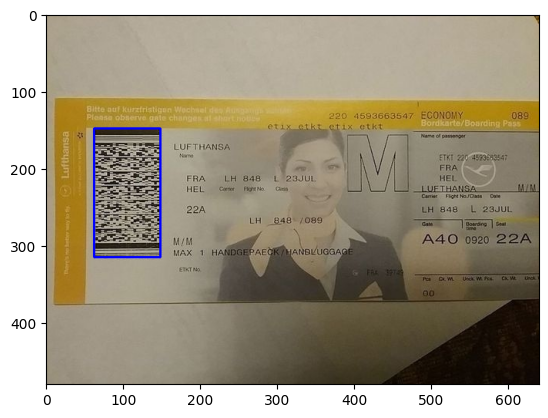

In [17]:
%matplotlib inline
img = cv2.imread(file_path)
H, W, _ = img.shape
for bbox in result[0].boxes.data.cpu().numpy():
    x0, y0, x1, y1, conf, pred = bbox
    if int(np.round(pred)) == 0:
        cv2.rectangle(img, pt1=(int(x0), int(y0)), pt2=(int(x1), int(y1)), color=(0,0,255), thickness=int((H+W)/500))
    else:
        cv2.rectangle(img, pt1=(int(x0), int(y0)), pt2=(int(x1), int(y1)), color=(255,0,0), thickness=int((H+W)/500))

plt.imshow(img[:,:,::-1])
plt.show()


In [18]:
device = torch.device('cuda:1')
model = YOLO("./yolo.yaml");
model.to(device);

WARNING ⚠️ no model scale passed. Assuming scale='nn'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       232  ultralytics.nn.modules.conv.Conv             [3, 8, 3, 2]                  
  1                  -1  1      1184  ultralytics.nn.modules.conv.Conv             [8, 16, 3, 2]                 
  2                  -1  1      1888  ultralytics.nn.modules.block.C2f             [16, 16, 1, True]             
  3                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  4                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  5                  -1  1     16240  ultralytics.nn.modules.conv.Conv             [32, 56, 3, 2]                
  6                  -1  1     22288  ultralytics.nn.modules.block.C2f             [56, 56, 1, True]             
  7                  -1  1     2

In [19]:
model.train(data="coco.yaml", epochs=200, imgsz=640, patience=10)

New https://pypi.org/project/ultralytics/8.0.203 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=./yolo.yaml, data=coco.yaml, epochs=200, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:1, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

KeyboardInterrupt: 